In [1]:
import numpy as np
import lysis
import os

import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from matplotlib.colors import BoundaryNorm, ListedColormap

from IPython.display import HTML
plt.rcParams["animation.html"] = "jshtml"

In [2]:
e = lysis.util.Experiment(os.path.join("..", "..", "data"), experiment_code="2023-01-18-1700")
e.read_file()
rng = np.random.default_rng()
file_code = ".f-normal-ifort.dat"

In [3]:
print(e)

experiment_code : 2023-01-18-1700
data_filenames  : unbinding_time    : tsectPA.dat
                  lysis_time        : lysismat.dat
                  total_lyses       : lenlysisvect.dat
                  degradation_state : deg.dat
micro_params    : None
macro_params    : binding_rate       : 0.1
                  pore_size          : 0.00010135
                  diffusion_coeff    : 5e-07
                  binding_sites      : 427
                  forced_unbind      : 0.0852
                  average_bind_time  : 27.8
                  grid_node_distance : 1.0862
                  cols               : 9
                  rows               : 12
                  full_row           : 26
                  xz_row             : 17
                  total_edges        : 303
                  total_fibers       : 225
                  empty_rows         : 3
                  last_empty_edge    : 77
                  total_molecules    : 430
                  moving_probability : 0.2
  

In [4]:
mol_location = np.fromfile(os.path.join(e.os_path, "m_loc" + file_code), dtype=np.int32)
mol_status = np.fromfile(os.path.join(e.os_path, "m_bound" + file_code), dtype=np.int32)
tsave = np.fromfile(os.path.join(e.os_path, "tsave" + file_code))

In [5]:
mol_location = mol_location.reshape(e.macro_params.total_trials, e.macro_params.number_of_saves, e.macro_params.total_molecules)
mol_status = mol_status.reshape(e.macro_params.total_trials, e.macro_params.number_of_saves, e.macro_params.total_molecules)
tsave = tsave.reshape(e.macro_params.total_trials, e.macro_params.number_of_saves)

In [6]:
mol_status = mol_status.astype(np.bool_)

In [7]:
def plot_coords(i, j):
    x = j
    y = i
    if j % 3 == 0:
        return x / 3.0, y + 0.5
    if j % 3 == 1:
        return (x - 1) / 3.0, y
    if j % 3 == 2:
        return (x - 2) / 3.0 + 0.5, y

In [8]:
x = np.empty((e.macro_params.total_trials, e.macro_params.number_of_saves, e.macro_params.total_molecules), dtype=float)
y = np.empty((e.macro_params.total_trials, e.macro_params.number_of_saves, e.macro_params.total_molecules), dtype=float)
for run in range(e.macro_params.total_trials):
    for t in range(e.macro_params.number_of_saves):
        for k in range(e.macro_params.total_molecules):
            i, j = lysis.from_fortran_edge_index(mol_location[run, t, k]-1, e.macro_params.rows, e.macro_params.cols)
            x[run, t, k], y[run, t, k] = plot_coords(i, j)
d = rng.random(size=(e.macro_params.total_trials, e.macro_params.number_of_saves, e.macro_params.total_molecules))
d = (d - 0.5) / 2.0
x += d
d = rng.random(size=(e.macro_params.total_trials, e.macro_params.number_of_saves, e.macro_params.total_molecules))
d = (d - 0.5) / 2.0
y += d

In [9]:
cmap = ListedColormap(['green', 'red'])
bounds=[0,.5,1]
norm = BoundaryNorm(bounds, cmap.N)

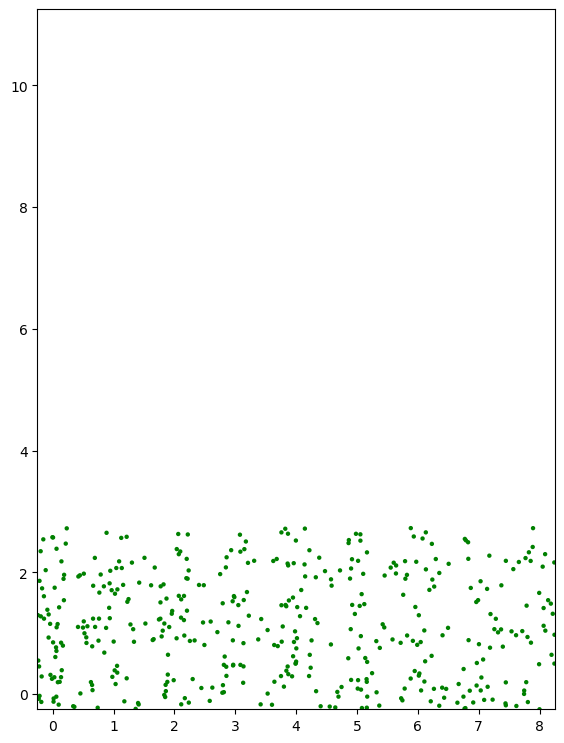

In [10]:
run = 2

plt.ioff()
fig = plt.figure(figsize=(7, 7))
ax = fig.add_axes([0, 0, 1, 1])#, frameon=False)
vmin = 0
vmax = e.macro_params.cols - 1

ydiff = e.macro_params.rows - e.macro_params.cols

ax.set_xlim(vmin - 0.25, vmax + 0.25)
ax.set_ylim(vmin - 0.25, vmax + ydiff + 0.25)
ax.set_aspect('equal')
fig.canvas.draw()
scatt = ax.scatter(x[run, 0], y[run, 0], 
                   s=10, marker='o', linewidths=0,
                   c=mol_status[run, 0], cmap=cmap, norm=norm
                   )

def update(frame_number):
    scatt.set_array(mol_status[run, frame_number])
    scatt.set_offsets(np.append((x[run, frame_number],), (y[run, frame_number],), axis=0).T)
    
animation = FuncAnimation(fig, update, frames=np.arange(e.macro_params.number_of_saves), interval=200)

#HTML(animation.to_jshtml())
HTML(animation.to_html5_video())